# Comparing CLMM to NumCosmo
This notebook compares `CLMM` to `NumCosmo`.

In [1]:
import numpy as np
import cluster_toolkit as ct
from astropy import constants, cosmology, units
import math

In [2]:
# For NumCosmo
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [3]:
import sys
import os

os.environ['CLMM_MODELING_BACKEND'] = 'ccl'

from clmm import theory as pp

/Users/combet/anaconda3/envs/clmmenv/lib/python3.8/site-packages/clmm-0.9.0-py3.8.egg/clmm/theory/__init__.py:33: UserWarning: CLMM Backend requested `ccl' is not available, trying others...


## Configuration

### Cosmology

In [4]:
# If CCL is installed, define a CCL cosmology object
# import pyccl as ccl
# cosmo_ccl = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96)

# If CCL is not installed, use astropy instead with the following lines
#from astropy.cosmology import FlatLambdaCDM
#astropy_cosmology_object = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
#cosmo_ccl = pp.cclify_astropy_cosmo(astropy_cosmology_object)

cosmo_ccl = pp.Cosmology (H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045)


### Cluster/source config

In [5]:
# Select density profile and profile parametrization options
density_profile_parametrization = 'nfw'
mass_Delta            = 200    # Mass defintion: mean matter density
cluster_mass          = 1.0e15 # Msun
cluster_concentration = 4.0
z_max                 = 3.0
z_cluster             = 1.0
z_source              = 2.0

### Vectors for inputs

In [6]:
z_a = np.linspace (0.01, 3.0, 1000)
a_a = 1.0 / (1.0 + z_a)
r3d = np.logspace (-2, 2, 100)

### NumCosmo
Pass configs to `NumCosmo`

In [7]:
#########################
# Initializing NumCosmo #
#########################
Ncm.cfg_init ()

##################
# Set Cosmology ##
##################
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo.omega_x2omega_k ()

cosmo.props.w  = -1.0
cosmo.props.H0 = cosmo_ccl['H0']

cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b0'])
cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_dm0'])
cosmo.param_set_by_name ("w",      -1.0)
cosmo.param_set_by_name ("Omegak",  0.0)
cosmo.param_set_by_name ("Tgamma0", 0.0)

##########################
# Config Cluster/Source ##
##########################

# NumCosmo Density profile
dp                   = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
dp.props.log10MDelta = math.log10 (cluster_mass)
dp.props.cDelta      = cluster_concentration

dist = Nc.Distance.new (z_max)
smd  = Nc.WLSurfaceMassDensity.new (dist)

smd.prepare (cosmo)

## Comparisons

### Function to make automatic comparisons

In [8]:
import pylab as plt
def compare(x, y_clmm, y_nc, x_name='x', y_name='func', subplots_pars={'figsize':(6, 4)}):
    clmm_name, nc_name = '%s_{clmm}'%y_name, '%s_{nc}'%y_name
    diff = y_nc/y_clmm - 1.
    print('rel diff min: %g\nrel diff max: %g'%(min(abs(diff)), max(abs(diff))))
    fig, axs = plt.subplots(2, sharex=True, **subplots_pars)
    fig.subplots_adjust(hspace=0)
    
    axs[0].plot(x, y_clmm, label='clmm', lw=3)
    axs[0].plot(x, y_nc, label='nc')
    axs[1].plot(x, diff, c='r')
    axs[1].axhline(0, ls=':', c='0', lw=.5)

    axs[0].legend()
    axs[0].set_ylabel('$%s$'%y_name)
    axs[1].set_xlabel('$%s$'%x_name)
    axs[1].set_ylabel('$%s/%s-1$'%(nc_name, clmm_name))
    
    return fig, axs

### Quick test of all theory function

rel diff min: 6.66134e-16
rel diff max: 4.55525e-13


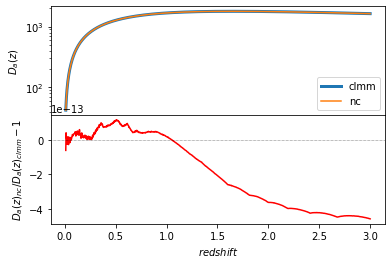

In [9]:
Da_a    = cosmo_ccl.eval_da_a1a2(a_a)
nc_Da_a = np.array ([dist.angular_diameter (cosmo, z) * cosmo.RH_Mpc () for z in  z_a])

fig, axs = compare (z_a, Da_a, nc_Da_a, x_name='redshift', y_name='D_a(z)')
axs[0].set_yscale ('log')


rel diff min: 4.44089e-16
rel diff max: 5.31575e-13


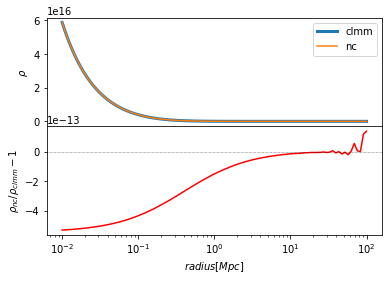

In [10]:
rho    = pp.compute_3d_density (r3d, mdelta = cluster_mass, cdelta = cluster_concentration,
                            z_cl = z_cluster, cosmo = cosmo_ccl, delta_mdef = mass_Delta)
nc_rho = np.array ([dp.eval_density (cosmo, r3d_i, z_cluster) for r3d_i in r3d])

fig, axs = compare(r3d, rho, nc_rho, x_name='radius [Mpc]', y_name='\\rho')
axs[0].set_xscale('log')

rel diff min: 1.3539e-10
rel diff max: 1.8188e-10


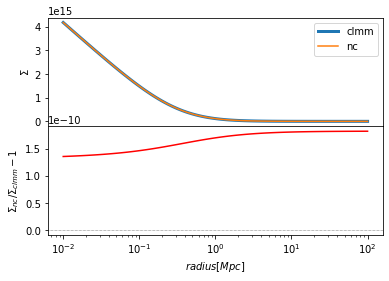

In [11]:
Sigma    = pp.compute_surface_density (r3d, cluster_mass, cluster_concentration, z_cl=z_cluster,
                                       cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                                       halo_profile_model='nfw')
nc_Sigma = np.array ([smd.sigma (dp, cosmo, r3d_i, z_cluster) for r3d_i in r3d])

fig, axs = compare (r3d, Sigma, nc_Sigma, x_name='radius [Mpc]', y_name='\\Sigma')
axs[0].set_xscale ('log')

rel diff min: 1.46416e-11
rel diff max: 7.92938e-10


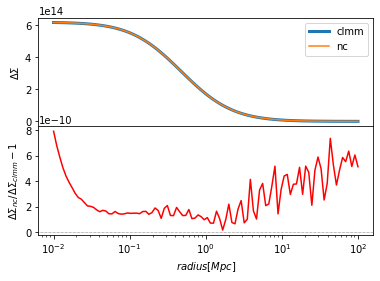

In [12]:
DeltaSigma    = pp.compute_excess_surface_density(r3d, cluster_mass, cluster_concentration,
                                                  z_cl=z_cluster, cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                                                  halo_profile_model='nfw')

nc_SigmaMean  = np.array ([smd.sigma_mean (dp, cosmo, r3d_i, z_cluster) for r3d_i in r3d])
nc_DeltaSigma = nc_SigmaMean - nc_Sigma

fig, axs = compare(r3d, DeltaSigma, nc_DeltaSigma, x_name='radius [Mpc]', y_name=r'\Delta\Sigma')
axs[0].set_xscale('log')

In [13]:
Sigmac = pp.compute_critical_surface_density (cosmo_ccl, z_cluster = z_cluster, z_source = z_source)
nc_Sigmac = smd.sigma_critical (cosmo, z_source, z_cluster, z_cluster)

print ("% 22.15g % 22.15g %e" % (Sigmac, nc_Sigmac, Sigmac / nc_Sigmac - 1.0))

  2.68928684121681e+15   2.68928684121852e+15 -6.347145e-13


rel diff min: 1.40068e-11
rel diff max: 7.92304e-10


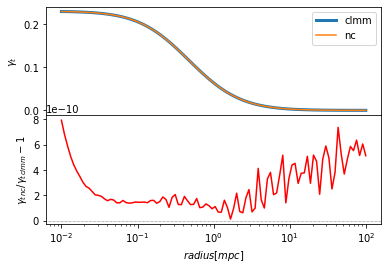

In [14]:
gammat    = pp.compute_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, z_cluster=z_cluster, 
                                        z_source=z_source, cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                                        halo_profile_model='nfw', z_src_model='single_plane')

nc_gammat = np.array ([smd.shear (dp, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

fig, axs = compare(r3d, gammat, nc_gammat, x_name='radius [mpc]', y_name=r'{\gamma_t}')
axs[0].set_xscale('log')

rel diff min: 1.34755e-10
rel diff max: 1.81245e-10


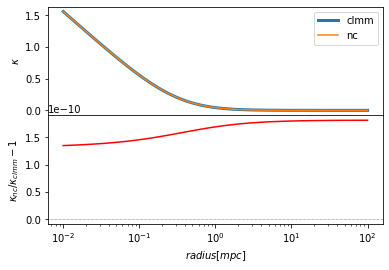

In [15]:
kappa = pp.compute_convergence(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                               z_cluster=z_cluster, z_source=z_source,
                               cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                               halo_profile_model='nfw', 
                               z_src_model='single_plane')

nc_kappa = np.array ([smd.convergence (dp, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

fig, axs = compare(r3d, kappa, nc_kappa, x_name='radius [mpc]', y_name=r'\kappa')
axs[0].set_xscale('log')


rel diff min: 1.73128e-11
rel diff max: 1.66344e-08


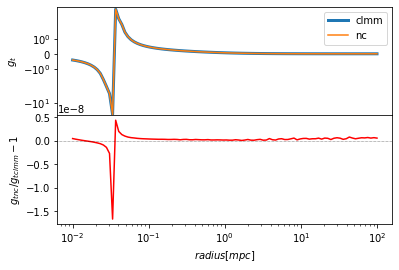

In [16]:
gt = pp.compute_reduced_tangential_shear(r3d, mdelta=cluster_mass, cdelta=cluster_concentration, 
                                         z_cluster=z_cluster, z_source=z_source, cosmo=cosmo_ccl, delta_mdef=mass_Delta, 
                                         halo_profile_model='nfw', z_src_model='single_plane')
nc_gt = np.array ([smd.reduced_shear (dp, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

fig, axs = compare(r3d, gt, nc_gt, x_name='radius [mpc]', y_name=r'{g_t}')
axs[0].set_xscale('log')
axs[0].set_yscale('symlog')


In [17]:
nc_mu = np.array ([smd.magnification (dp, cosmo, r3d_i, z_source, z_cluster, z_cluster) for r3d_i in r3d])

### Save the numcosmo outputs

In [18]:
np.savetxt('radial_profiles.txt',
           np.array([r3d,  nc_rho, nc_Sigma, nc_DeltaSigma, nc_gammat, nc_kappa, nc_gt, nc_mu]).T,
           header='r3d  rho Sigma DeltaSigma gammat kappa gt mu')

In [19]:
np.savetxt('angular_diameter_distance.txt',
           np.array([a_a, z_a, nc_Da_a]).T,
           header='a_a z_a Da_a')

In [20]:
config_dict = {'dl': dist.angular_diameter (cosmo, z_cluster) * cosmo.RH_Mpc (),
               'z_source': z_source,
               'cluster_mass': cluster_mass,
               'G[m3/km.s2]': Ncm.C.G(),
               'aexp_cluster': 1./(1.+z_cluster),
               'density_profile_parametrization': density_profile_parametrization,
               'ds': dist.angular_diameter (cosmo, z_source) * cosmo.RH_Mpc (),
               'cosmo_Ob0': cosmo_ccl['Omega_b0'],
               'aexp_source': 1./(1.+z_source),
               'dsl': dist.angular_diameter_z1_z2 (cosmo, z_cluster, z_source) * cosmo.RH_Mpc (),
               'z_cluster': z_cluster,
               'mass_Delta': mass_Delta,
               'lightspeed[km/s]': Ncm.C.c()/1000.,
               'cosmo_H0': cosmo_ccl['H0'],
               'cluster_concentration': cluster_concentration,
               'cosmo_Om0': cosmo_ccl['Omega_m0'],
               'nc_Sigmac': nc_Sigmac,
               'Msun[kg]': Ncm.C.mass_solar(),
               'pc_to_m': Ncm.C.pc()}

import json
with open('config.json', 'w') as fp:
    json.dump(config_dict, fp)